<div class='alert alert-info alert-block' align='center'><h1><b>Problem Statement<b></h1></div>


FashionKart allows consumers to buy the latest products from e-commerce platforms. Customers can leave reviews of products and experiences to help other users make their purchase choices. 

Given the dataset of product reviews and recommendation status, build a text classification model that can correctly identify the users who will recommend the product in the future. 

Also, provide the key topics/themes emerging from the customer reviews and visualize them.

#### Data Files
**dataset.csv** file is the main file that contains the reviews and corresponding customer recommendation values. There are only two columns in the 
data - review and recommendation.  
 
#### Approach  
Build a text classifier that can predict whether the user will recommend the product or not. Apart from the text classifier, use relevant algorithms to extract and visualize the key topics from the reviews.  
 
#### Evaluation Metric 
The metric used for evaluating the performance of the model is accuracy and auc score (test data to be split from dataset.csv)   
Accuracy = Correct Predictions/Total Number of Predictions 
  
#### Deliverables 
Well-commented Jupyter notebook including EDA, data processing steps, modeling, model performance comparison, and topic modeling with visualization.    

<div class='alert alert-info alert-block' align='center'><h1><b>Text Classification & Topic Modeling for Product Reviews<b></h1></div>

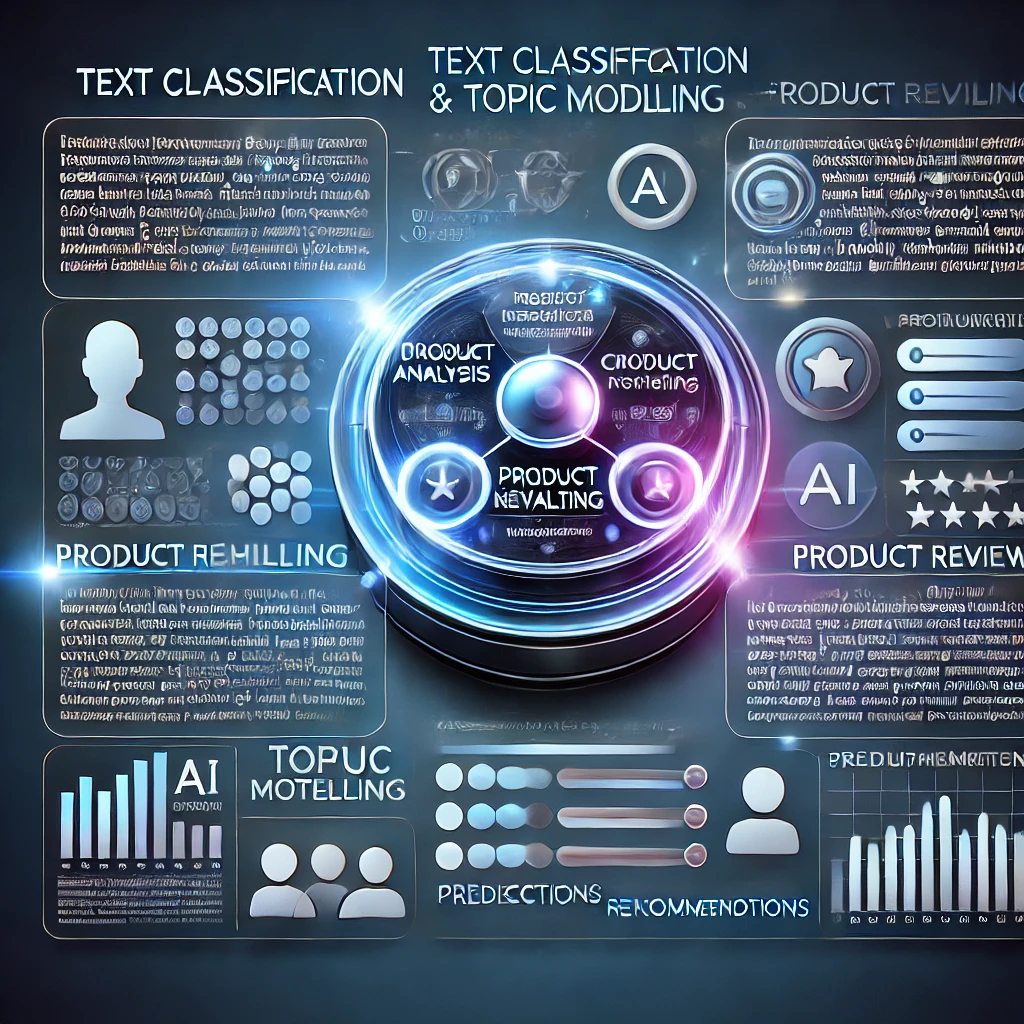

In [166]:
Image(r'C:\Users\shubh\Desktop\python\upgrad\Case Study\NLP\txtp.jpg',width=1200,height=500)

<div class='alert alert-info alert-block' align='center'><h3><b>Importing Libraries and Understanding the data<b></h3</div>

In [33]:
# importing libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud

from collections import Counter
import string
import re
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [35]:
# loading the dataset
df = pd.read_csv(r"dataset.csv")

# top n rows 
df.head()

,Review,Recommend
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [37]:
# number of rows and columns 
df.shape

(23486, 2)

In [39]:
# basic inforamtion about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Recommend  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [41]:
# checking for null records
df.isnull().sum()

Review       845
Recommend      0
dtype: int64

In [43]:
# dropping null records 
df.dropna(inplace=True)

In [45]:
# checking for duplicates records
df['Review'].duplicated().sum()

7

In [47]:
# dropping duplicated records
df['Review'].drop_duplicates(inplace=True)

In [49]:
# rows after dropping null and duplicated records
df.shape

(22641, 2)

<div class='alert alert-info alert-block' align='center'><h3><b>Exploratory Data Analysis<b></h3></div>

In [52]:
df['Recommend'].value_counts()

Recommend
1    18540
0     4101
Name: count, dtype: int64

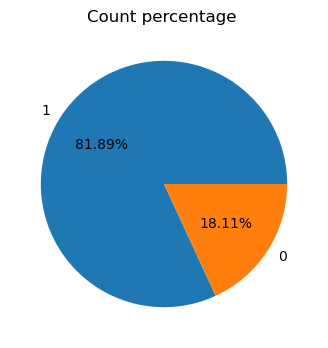

In [54]:
value_count_pct = df['Recommend'].value_counts(normalize=True)

plt.figure(figsize=(4,4))
plt.pie(value_count_pct.values , labels=value_count_pct.keys() , autopct='%0.2f%%')
plt.title('Count percentage ')
plt.show()

In [56]:
# setting data type for review as string 
df['Review'] = df['Review'].astype('str')

In [58]:
# Number of words in Review column
df['words'] = df['Review'].apply(lambda x : len(x.split(' ')))

In [60]:
df.head()

,Review,Recommend,words
0,Absolutely wonderful - silky and sexy and comf...,1,8
1,Love this dress! it's sooo pretty. i happene...,1,67
2,I had such high hopes for this dress and reall...,0,98
3,"I love, love, love this jumpsuit. it's fun, fl...",1,22
4,This shirt is very flattering to all due to th...,1,36


In [62]:
# average length of the review for 0 and 1 

print('For recommend 1 ',round(df[df['Recommend']==1]['words'].mean()))
print('For recommend 0 ',round(df[df['Recommend']==0]['words'].mean()))

For recommend 1  60
For recommend 0  62


### Text Cleaning

In [65]:
def text_transf(review):
    # lowercase the review 
    review = review.lower()
    
    # cleaning Review
    review = re.sub('[()!?]', ' ', review)
    review = re.sub('\[.*?\]',' ', review)
    #remove non alphanumeric occurences
    review = re.sub("[^a-z0-9]"," ", review)
    #remove the @mention
    review = re.sub("@[A-Za-z0-9_]+","", review)
    #remove the hastags
    review = re.sub("#[A-Za-z0-9_]+","", review)
    #remove any links 
    review = re.sub(r"http\S+", "", review)
    review = re.sub(r"www.\S+", "", review)

    tokens = word_tokenize(review)
    # remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(cleaned_tokens)

In [67]:
# applying text_transformation funtion to Review
df['clean_review'] = df['Review'].apply(text_transf)

In [69]:
# top 5 rows 
df.head()

,Review,Recommend,words,clean_review
0,Absolutely wonderful - silky and sexy and comf...,1,8,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,1,67,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,0,98,high hope dress really wanted work initially o...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,22,love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,1,36,shirt flattering due adjustable front tie perf...


In [71]:
# number of words in clean review
df['clean_words'] = df['clean_review'].apply(lambda x : len(x.split(' ')))

In [73]:
df.head()

,Review,Recommend,words,clean_review,clean_words
0,Absolutely wonderful - silky and sexy and comf...,1,8,absolutely wonderful silky sexy comfortable,5
1,Love this dress! it's sooo pretty. i happene...,1,67,love dress sooo pretty happened find store gla...,31
2,I had such high hopes for this dress and reall...,0,98,high hope dress really wanted work initially o...,48
3,"I love, love, love this jumpsuit. it's fun, fl...",1,22,love love love jumpsuit fun flirty fabulous ev...,14
4,This shirt is very flattering to all due to th...,1,36,shirt flattering due adjustable front tie perf...,16


In [75]:
# average length of the clean review for 0 and 1 

print('For recommend 1 ',round(df[df['Recommend']==1]['clean_words'].mean()))
print('For recommend 0 ',round(df[df['Recommend']==0]['clean_words'].mean()))

For recommend 1  29
For recommend 0  29


<div class="alert alert-info alert-block" align="center"><h4>Splitting data into train and test</h4></div>

In [83]:
X_train , X_test , y_train , y_test = train_test_split(df['clean_review'], df['Recommend'] ,test_size=0.2, random_state=23)

In [85]:
X_train.shape

(18112,)

In [87]:
X_test.shape

(4529,)

In [89]:
y_train.value_counts()

Recommend
1    14841
0     3271
Name: count, dtype: int64

In [91]:
y_test.value_counts()

Recommend
1    3699
0     830
Name: count, dtype: int64

<div class="alert alert-info alert-block" align="center"><h4>ML modelling and Performance Evaluation</h4></div>

#### Count Vectorizer Method

In [95]:
# making object for count vectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

# fitting and transforming train and test data into vector
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [97]:
models = [
    ('Logistic Regression' , LogisticRegression),
    ('Multinomial NB' , MultinomialNB),
    ('Random Forest' , RandomForestClassifier)
]

In [100]:
results = pd.DataFrame(columns=['ModelName','accuracy_score'])

for name , model in models:
    print('Name : ',name)
    print("Training and Evaluation DONE")
    model = model()
    model.fit(X_train_vec , y_train)
    y_pred = model.predict(X_test_vec)
    acc_score = accuracy_score(y_test , y_pred)
    results = pd.concat([results , pd.DataFrame({'ModelName':[name],'accuracy_score':[acc_score]})],ignore_index=True)

Name :  Logistic Regression
Training and Evaluation DONE
Name :  Multinomial NB
Training and Evaluation DONE
Name :  Random Forest
Training and Evaluation DONE


In [101]:
results

,ModelName,accuracy_score
0,Logistic Regression,0.887392
1,Multinomial NB,0.886730
2,Random Forest,0.852727


#### Term Frequency Inverse Document Frequency Method (TD-IDF)

In [104]:
# making object for TF-IDF
vectorizer_tfidf = TfidfVectorizer()

# fitting and trasforming the data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)

X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [106]:
results = pd.DataFrame(columns=['ModelName','accuracy_score'])

for name , model in models:
    print('Name : ',name)
    model = model()
    model.fit(X_train_tfidf , y_train)
    y_pred = model.predict(X_test_tfidf)
    acc_score = accuracy_score(y_test , y_pred)
    results = pd.concat([results , pd.DataFrame({'ModelName':[name],'accuracy_score':[acc_score]})],ignore_index=True)

Name :  Logistic Regression
Name :  Multinomial NB
Name :  Random Forest


In [107]:
results

,ModelName,accuracy_score
0,Logistic Regression,0.890042
1,Multinomial NB,0.823361
2,Random Forest,0.850740


##### Logistic regression model giving best score

<div class="alert alert-info alert-block" align="center"><h3>Topic Modelling</h3></div>

In [114]:
review_term = pd.Series(df['clean_review'].apply(lambda x : x.split()))

In [116]:
dictionary = corpora.Dictionary(review_term)

In [117]:
# Preapre the DTM(Document Term Matrix) from the term dictionary 
doc_term_matrix = [dictionary.doc2bow(rev) for rev in review_term]

In [119]:
# Build the LDA model for topic extraction 
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=10, 
                chunksize=500,
                passes=10)
    

In [120]:
#print the top 10 topics 
lda_model.print_topics()


[(0,
  '0.115*"skirt" + 0.073*"waist" + 0.028*"hip" + 0.021*"suit" + 0.021*"otherwise" + 0.019*"high" + 0.018*"thigh" + 0.018*"figure" + 0.015*"27" + 0.014*"hourglass"'),
 (1,
  '0.110*"pant" + 0.069*"jean" + 0.060*"pair" + 0.035*"leg" + 0.027*"recommend" + 0.020*"stretch" + 0.018*"highly" + 0.016*"heel" + 0.014*"wash" + 0.013*"sandal"'),
 (2,
  '0.065*"dress" + 0.031*"love" + 0.024*"wear" + 0.014*"time" + 0.014*"one" + 0.014*"perfect" + 0.014*"great" + 0.013*"compliment" + 0.013*"comfortable" + 0.013*"wore"'),
 (3,
  '0.078*"year" + 0.037*"last" + 0.024*"wrap" + 0.022*"old" + 0.019*"pencil" + 0.018*"meant" + 0.018*"frumpy" + 0.017*"ago" + 0.017*"event" + 0.015*"call"'),
 (4,
  '0.142*"sweater" + 0.053*"jacket" + 0.032*"warm" + 0.026*"coat" + 0.025*"cardigan" + 0.023*"sleeve" + 0.020*"soft" + 0.017*"weather" + 0.015*"cozy" + 0.013*"fall"'),
 (5,
  '0.135*"super" + 0.036*"cute" + 0.022*"comfy" + 0.022*"clothing" + 0.022*"baggy" + 0.020*"soft" + 0.016*"awesome" + 0.015*"arrived" + 0.014*

### Topic visualization

In [123]:
# Visualize the topics
pyLDAvis.enable_notebook()
# feed the LDA model into the pyLDAvis instance
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)     
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.230954  0.039444       1        1  29.901139
8      0.247831  0.052216       2        1  22.465266
7      0.217773 -0.045884       3        1  15.117113
2      0.183704 -0.085540       4        1  11.250295
6      0.118757  0.095922       5        1   8.727477
4     -0.177723 -0.158847       6        1   3.305891
1     -0.122832 -0.226893       7        1   3.024739
0     -0.195711  0.330069       8        1   2.730274
5     -0.235684  0.020128       9        1   2.022319
3     -0.267069 -0.020617      10        1   1.455487, topic_info=         Term          Freq         Total Category  logprob  loglift
58       size   9572.000000   9572.000000  Default  30.0000  30.0000
451   sweater   3099.000000   3099.000000  Default  29.0000  29.0000
10      dress  12200.000000  12200.000000  Default  28.0000  28.0000
111     skirt   2641.000000   2641.000000  Default  27.0000  27.0000
294     waist   2584.000000   2584.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3605      win     74.717115     75.652127  Topic10  -4.8582   4.2174
2132    image     72.714842     73.649808  Topic10  -4.8854   4.2171
455      week     92.689731    229.809620  Topic10  -4.6426   3.3218
1263     know     91.169300    487.164453  Topic10  -4.6592   2.5539
757   similar     78.635536    225.856586  Topic10  -4.8071   3.1748

[565 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
591       1  0.998899          0
313       1  0.998091          1
963       1  0.998306         10
949       1  0.998154        115
1249      1  0.998309         12
...     ...       ...        ...
2783     10  0.986812       yarn
220      10  0.998455       year
1497      3  0.902514     yellow
1497      5  0.093927     yellow
1758      4  0.990138  yesterday

[914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 8, 3, 7, 5, 2, 1, 6, 4])